## import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
import praw #reddit data api
import ffn #for loading financial data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import re #regex
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #VADER sentiment model
import requests
import json
import csv
import time
import datetime

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ffn\core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import tensorflow as tf
from tensorflow import keras
tf.test.gpu_device_name() #run to make sure tensorflow is connected to gpu (if applicable)

'/device:GPU:0'

# positive/negative sentiment analysis using VADER

## get comments from reddit using pushshift and praw

In [3]:
#function to get data from pushshift api
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

#get relevant data from data extracted using previous function
def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)

In [4]:
#Subreddit to query
sub='wallstreetbets'
#before and after dates
before = "1594339200" #july 10 2020
after = "1498867200" #july 1 2017
#query string
query = "Daily Discussion Thread"
subCount = 0
subStats = []

In [5]:
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    data = getPushshiftData(query, after, before, sub)

https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1498867200&before=1594339200&subreddit=wallstreetbets
100
2018-04-25 08:08:40
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1524658120&before=1594339200&subreddit=wallstreetbets
99
2018-09-10 07:12:44
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1536577964&before=1594339200&subreddit=wallstreetbets
100
2019-01-21 06:05:54
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1548068754&before=1594339200&subreddit=wallstreetbets
100
2019-06-10 07:05:59
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1560164759&before=1594339200&subreddit=wallstreetbets
100
2019-10-10 07:05:28
https://api.pushshift.io/reddit/search/submission/?title=Daily Discussion Thread&size=1000&after=1570705528&before=1594339200&

In [6]:
#organize data into dataframe
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_1=pd.DataFrame(data)
df_1=df_1[df_1['flair']=='Daily Discussion']

In [7]:
#connect to reddit api
reddit = praw.Reddit(client_id='hTZb6J3MQQKw8w', client_secret='GGaCs3InUDmCm6Jh6EC8ahGg_qI', user_agent='Arjun')

In [8]:
#collect comments using praw
comments_by_day=[]
for url in df_1['url'].tolist():
    try:
        submission = reddit.submission(url=url)
        submission.comments.replace_more(limit=0)
        comments=list([(comment.body) for comment in submission.comments])
    except:
        comments=None
    comments_by_day.append(comments)

In [9]:
## run vader sentiment analyzer

analyser = SentimentIntensityAnalyzer()

scores=[]
for comments in comments_by_day:
    sentiment_score=0
    try:
        for comment in comments:
            sentiment_score=sentiment_score+analyser.polarity_scores(comment)['compound']
    except TypeError:
        sentiment_score=0
    
    scores.append(sentiment_score)
    
df_1['sentiment score']=scores

In [10]:
## merge with spy price and plot

spy=ffn.get('spy', start='2010-01-01')
spy_vals=[]
for date in df_1['date'].tolist():
    try:
        spy_vals.append(float(spy.loc[date]))
    except KeyError:
        spy_vals.append(None)
        
df_1['spy']=spy_vals

In [11]:
df_1=df_1[['date','sentiment score','spy']]
df_1=df_1.set_index('date')
df_1=df_1[df_1['spy'].notna()]

In [12]:
df_1.to_csv('positive+negative_sentiment_data_1.csv')

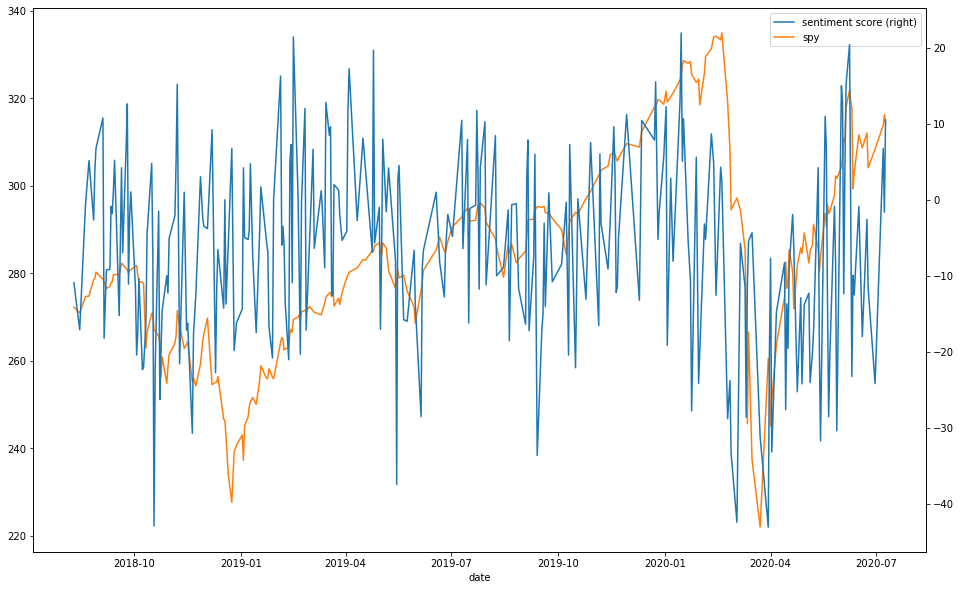

In [13]:
df_1.plot(secondary_y='sentiment score', figsize=(16, 10));

In [14]:
## fourier transform

close_fft = np.fft.fft(np.asarray(df_1['sentiment score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [5, 10, 15, 20]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_1['fourier '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


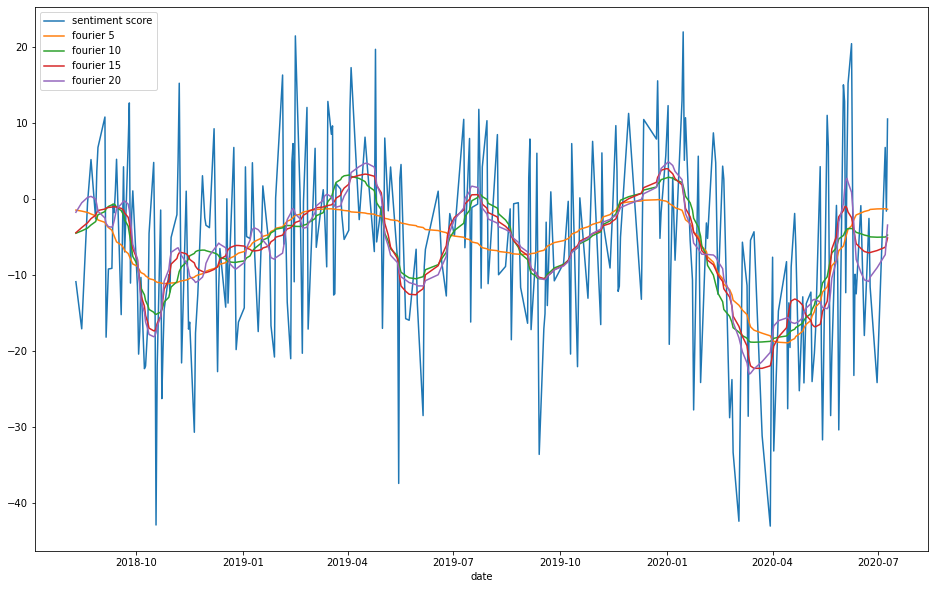

In [15]:
df_1[['sentiment score', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20']].plot(figsize=(16, 10));

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


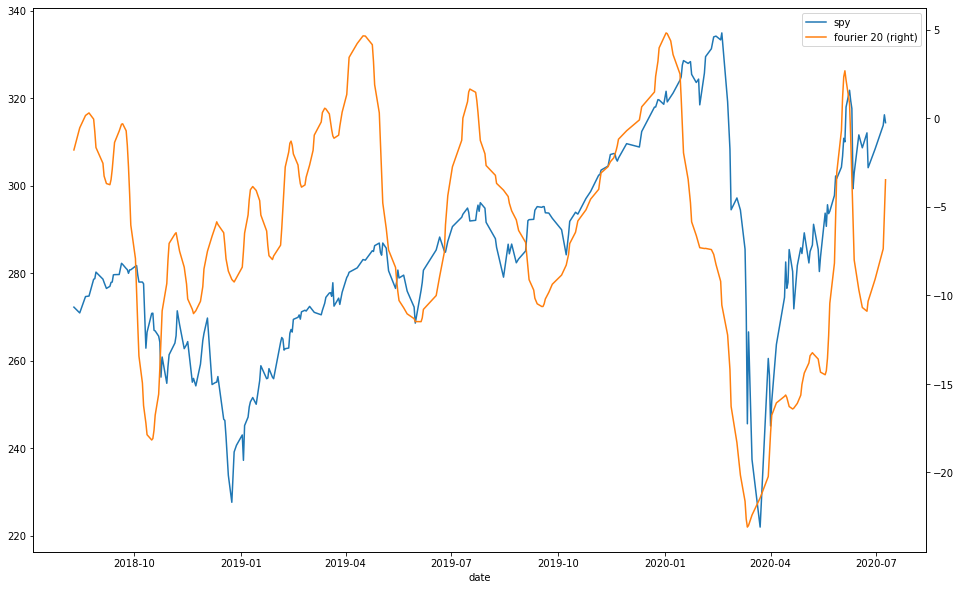

In [16]:
df_1[['spy', 'fourier 20']].plot(secondary_y='fourier 20', figsize=(16, 10));

In [17]:
#normalize
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
df_1['norm_price']=sc.fit_transform(df_1['spy'].to_numpy().reshape(-1, 1))
df_1['spy log']=np.log(df_1['spy']/df_1['spy'].shift(1))
df_1['norm_sentiment']=sc.fit_transform(df_1['sentiment score'].to_numpy().reshape(-1, 1))
df_1['norm_fourier5']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 5'].to_numpy()])).reshape(-1, 1))
df_1['norm_fourier10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 10'].to_numpy()])).reshape(-1, 1))
df_1['norm_fourier15']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 15'].to_numpy()])).reshape(-1, 1))
df_1['norm_fourier20']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_1['fourier 20'].to_numpy()])).reshape(-1, 1))

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


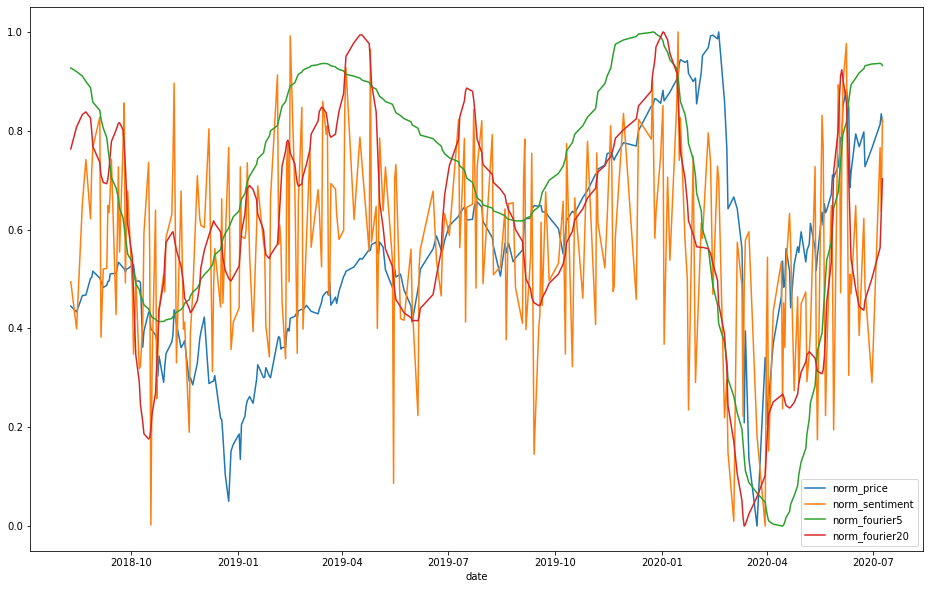

In [18]:
df_1[['norm_price', 'norm_sentiment', 'norm_fourier5', 'norm_fourier20']].plot(figsize=(16, 10));

# bullish/bearish sentiment analysis using keywords

## get submission titles using pushshift

In [19]:
def getPushshiftData(query, after, before, sub):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    print(url)
    
    r = requests.get(url)
    data = json.loads(r.text)
    
    return data['data']

def collectSubData(subm):
    subData = [subm['id'], subm['title'], subm['url'], datetime.datetime.fromtimestamp(subm['created_utc']).date()]
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    subData.append(flair)
    subStats.append(subData)

In [20]:
#Subreddit to query
sub='wallstreetbets'
#before and after dates
before = "1594339200" #july 10 2020
after = "1498867200" #july 1 2017
query = ""
subCount = 0
subStats = []

In [21]:
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered 
# from the 'after' date up until before date
while len(data) > 0:
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    after = data[-1]['created_utc']
    try:
        data = getPushshiftData(query, after, before, sub)
    except:
        pass

https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1498867200&before=1594339200&subreddit=wallstreetbets
100
2017-07-02 22:16:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499048207&before=1594339200&subreddit=wallstreetbets
100
2017-07-03 19:02:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499122977&before=1594339200&subreddit=wallstreetbets
100
2017-07-05 09:35:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499261734&before=1594339200&subreddit=wallstreetbets
100
2017-07-05 18:50:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499295041&before=1594339200&subreddit=wallstreetbets
100
2017-07-06 15:20:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499368827&before=1594339200&subreddit=wallstreetbets
100
2017-07-07 11:48:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1499442485&bef

100
2017-08-09 03:05:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502262312&before=1594339200&subreddit=wallstreetbets
100
2017-08-09 16:24:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502310259&before=1594339200&subreddit=wallstreetbets
100
2017-08-10 10:12:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502374348&before=1594339200&subreddit=wallstreetbets
100
2017-08-10 14:56:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502391391&before=1594339200&subreddit=wallstreetbets
100
2017-08-10 17:54:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502402061&before=1594339200&subreddit=wallstreetbets
100
2017-08-11 09:17:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1502457460&before=1594339200&subreddit=wallstreetbets
100
2017-08-11 15:58:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2017-09-21 15:37:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506022655&before=1594339200&subreddit=wallstreetbets
100
2017-09-22 10:31:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506090705&before=1594339200&subreddit=wallstreetbets
100
2017-09-22 21:43:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506131009&before=1594339200&subreddit=wallstreetbets
100
2017-09-24 19:36:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506296185&before=1594339200&subreddit=wallstreetbets
100
2017-09-25 14:29:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506364169&before=1594339200&subreddit=wallstreetbets
100
2017-09-26 09:34:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1506432894&before=1594339200&subreddit=wallstreetbets
100
2017-09-26 17:19:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2017-10-27 09:37:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509111469&before=1594339200&subreddit=wallstreetbets
100
2017-10-27 13:25:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509125118&before=1594339200&subreddit=wallstreetbets
100
2017-10-27 23:58:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509163084&before=1594339200&subreddit=wallstreetbets
100
2017-10-29 15:43:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509306217&before=1594339200&subreddit=wallstreetbets
100
2017-10-30 10:22:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509373322&before=1594339200&subreddit=wallstreetbets
100
2017-10-30 14:29:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1509388176&before=1594339200&subreddit=wallstreetbets
100
2017-10-31 08:00:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2017-11-30 13:32:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512066720&before=1594339200&subreddit=wallstreetbets
100
2017-12-01 08:26:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512134814&before=1594339200&subreddit=wallstreetbets
100
2017-12-01 12:11:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512148292&before=1594339200&subreddit=wallstreetbets
100
2017-12-01 17:36:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512167815&before=1594339200&subreddit=wallstreetbets
100
2017-12-02 19:37:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512261453&before=1594339200&subreddit=wallstreetbets
100
2017-12-03 20:29:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1512350958&before=1594339200&subreddit=wallstreetbets
100
2017-12-04 10:37:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-01-12 10:51:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1515772288&before=1594339200&subreddit=wallstreetbets
100
2018-01-12 19:21:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1515802883&before=1594339200&subreddit=wallstreetbets
100
2018-01-14 15:31:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1515961890&before=1594339200&subreddit=wallstreetbets
100
2018-01-14 15:31:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1515961890&before=1594339200&subreddit=wallstreetbets
100
2018-01-15 18:59:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1516060776&before=1594339200&subreddit=wallstreetbets
100
2018-01-16 13:43:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1516128238&before=1594339200&subreddit=wallstreetbets
100
2018-01-16 22:03:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-02-06 14:30:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1517945422&before=1594339200&subreddit=wallstreetbets
100
2018-02-06 16:35:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1517952929&before=1594339200&subreddit=wallstreetbets
100
2018-02-06 22:01:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1517972474&before=1594339200&subreddit=wallstreetbets
100
2018-02-07 11:03:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518019413&before=1594339200&subreddit=wallstreetbets
100
2018-02-07 15:36:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518035808&before=1594339200&subreddit=wallstreetbets
100
2018-02-07 21:43:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1518057809&before=1594339200&subreddit=wallstreetbets
100
2018-02-08 11:01:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-03-05 14:53:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520279582&before=1594339200&subreddit=wallstreetbets
100
2018-03-06 08:46:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520343975&before=1594339200&subreddit=wallstreetbets
100
2018-03-06 14:35:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520364903&before=1594339200&subreddit=wallstreetbets
100
2018-03-06 20:27:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520386043&before=1594339200&subreddit=wallstreetbets
100
2018-03-07 10:12:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520435556&before=1594339200&subreddit=wallstreetbets
100
2018-03-07 15:40:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1520455230&before=1594339200&subreddit=wallstreetbets
100
2018-03-08 04:06:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-04-01 22:36:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522636599&before=1594339200&subreddit=wallstreetbets
100
2018-04-02 12:37:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522687039&before=1594339200&subreddit=wallstreetbets
100
2018-04-02 15:22:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522696963&before=1594339200&subreddit=wallstreetbets
100
2018-04-02 22:02:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522720922&before=1594339200&subreddit=wallstreetbets
100
2018-04-03 10:21:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522765283&before=1594339200&subreddit=wallstreetbets
100
2018-04-03 16:20:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1522786849&before=1594339200&subreddit=wallstreetbets
100
2018-04-04 00:26:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-04-28 18:44:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1524955456&before=1594339200&subreddit=wallstreetbets
100
2018-04-29 20:15:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525047331&before=1594339200&subreddit=wallstreetbets
100
2018-04-30 11:41:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525102887&before=1594339200&subreddit=wallstreetbets
100
2018-04-30 20:12:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525133561&before=1594339200&subreddit=wallstreetbets
100
2018-05-01 13:20:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525195209&before=1594339200&subreddit=wallstreetbets
100
2018-05-01 16:55:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1525208153&before=1594339200&subreddit=wallstreetbets
100
2018-05-02 03:22:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-05-23 16:38:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527107891&before=1594339200&subreddit=wallstreetbets
100
2018-05-23 23:27:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527132472&before=1594339200&subreddit=wallstreetbets
100
2018-05-24 11:05:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527174340&before=1594339200&subreddit=wallstreetbets
100
2018-05-24 15:06:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527188782&before=1594339200&subreddit=wallstreetbets
100
2018-05-25 00:01:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527220914&before=1594339200&subreddit=wallstreetbets
100
2018-05-25 13:17:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1527268626&before=1594339200&subreddit=wallstreetbets
100
2018-05-26 00:34:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-06-14 16:19:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529007552&before=1594339200&subreddit=wallstreetbets
100
2018-06-14 22:06:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529028361&before=1594339200&subreddit=wallstreetbets
100
2018-06-15 09:34:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529069694&before=1594339200&subreddit=wallstreetbets
100
2018-06-15 11:45:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529077519&before=1594339200&subreddit=wallstreetbets
100
2018-06-15 14:25:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529087130&before=1594339200&subreddit=wallstreetbets
100
2018-06-15 18:21:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1529101295&before=1594339200&subreddit=wallstreetbets
100
2018-06-16 10:19:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-06-30 19:16:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530400577&before=1594339200&subreddit=wallstreetbets
100
2018-07-01 18:56:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530485768&before=1594339200&subreddit=wallstreetbets
100
2018-07-02 09:47:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530539240&before=1594339200&subreddit=wallstreetbets
100
2018-07-02 15:17:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530559071&before=1594339200&subreddit=wallstreetbets
100
2018-07-02 23:43:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530589414&before=1594339200&subreddit=wallstreetbets
100
2018-07-03 11:11:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1530630688&before=1594339200&subreddit=wallstreetbets
100
2018-07-03 14:50:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-07-24 09:34:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532439265&before=1594339200&subreddit=wallstreetbets
100
2018-07-24 12:49:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532450941&before=1594339200&subreddit=wallstreetbets
100
2018-07-24 16:02:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532462565&before=1594339200&subreddit=wallstreetbets
100
2018-07-24 22:30:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532485845&before=1594339200&subreddit=wallstreetbets
100
2018-07-25 09:55:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532526900&before=1594339200&subreddit=wallstreetbets
100
2018-07-25 12:32:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1532536372&before=1594339200&subreddit=wallstreetbets
100
2018-07-25 16:03:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-08-07 16:51:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533675068&before=1594339200&subreddit=wallstreetbets
100
2018-08-07 19:17:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533683840&before=1594339200&subreddit=wallstreetbets
100
2018-08-08 01:12:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533705148&before=1594339200&subreddit=wallstreetbets
100
2018-08-08 10:12:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533737578&before=1594339200&subreddit=wallstreetbets
100
2018-08-08 13:30:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533749434&before=1594339200&subreddit=wallstreetbets
100
2018-08-08 17:54:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1533765259&before=1594339200&subreddit=wallstreetbets
100
2018-08-08 23:59:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-08-23 17:40:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535060451&before=1594339200&subreddit=wallstreetbets
100
2018-08-24 08:01:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535112085&before=1594339200&subreddit=wallstreetbets
100
2018-08-24 11:37:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535125026&before=1594339200&subreddit=wallstreetbets
100
2018-08-24 15:40:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535139605&before=1594339200&subreddit=wallstreetbets
100
2018-08-24 19:56:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535155008&before=1594339200&subreddit=wallstreetbets
100
2018-08-25 12:29:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1535214595&before=1594339200&subreddit=wallstreetbets
100
2018-08-26 07:11:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-09-10 18:55:42
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536620142&before=1594339200&subreddit=wallstreetbets
100
2018-09-11 08:38:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536669491&before=1594339200&subreddit=wallstreetbets
100
2018-09-11 13:04:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536685495&before=1594339200&subreddit=wallstreetbets
100
2018-09-11 17:57:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536703076&before=1594339200&subreddit=wallstreetbets
100
2018-09-12 02:07:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536732477&before=1594339200&subreddit=wallstreetbets
100
2018-09-12 10:19:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1536761944&before=1594339200&subreddit=wallstreetbets
100
2018-09-12 13:08:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-09-27 07:06:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538046382&before=1594339200&subreddit=wallstreetbets
100
2018-09-27 11:17:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538061431&before=1594339200&subreddit=wallstreetbets
100
2018-09-27 13:53:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538070792&before=1594339200&subreddit=wallstreetbets
100
2018-09-27 16:40:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538080857&before=1594339200&subreddit=wallstreetbets
100
2018-09-27 19:14:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538090086&before=1594339200&subreddit=wallstreetbets
100
2018-09-28 00:57:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1538110673&before=1594339200&subreddit=wallstreetbets
100
2018-09-28 10:34:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-10-12 05:33:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539336800&before=1594339200&subreddit=wallstreetbets
100
2018-10-12 11:13:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539357190&before=1594339200&subreddit=wallstreetbets
100
2018-10-12 15:34:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539372849&before=1594339200&subreddit=wallstreetbets
100
2018-10-12 21:12:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539393167&before=1594339200&subreddit=wallstreetbets
100
2018-10-13 13:30:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539451858&before=1594339200&subreddit=wallstreetbets
100
2018-10-14 03:23:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1539501797&before=1594339200&subreddit=wallstreetbets
100
2018-10-14 18:05:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-10-31 16:57:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541019476&before=1594339200&subreddit=wallstreetbets
100
2018-11-01 06:21:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541067669&before=1594339200&subreddit=wallstreetbets
100
2018-11-01 13:29:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541093357&before=1594339200&subreddit=wallstreetbets
100
2018-11-01 17:43:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541108591&before=1594339200&subreddit=wallstreetbets
100
2018-11-02 06:35:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541154944&before=1594339200&subreddit=wallstreetbets
100
2018-11-02 13:49:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1541180961&before=1594339200&subreddit=wallstreetbets
100
2018-11-02 21:49:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-11-28 13:45:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543430747&before=1594339200&subreddit=wallstreetbets
100
2018-11-28 19:25:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543451114&before=1594339200&subreddit=wallstreetbets
100
2018-11-29 10:45:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543506332&before=1594339200&subreddit=wallstreetbets
100
2018-11-29 21:19:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543544385&before=1594339200&subreddit=wallstreetbets
100
2018-11-30 12:50:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543600254&before=1594339200&subreddit=wallstreetbets
100
2018-12-01 03:05:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1543651537&before=1594339200&subreddit=wallstreetbets
100
2018-12-01 20:52:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2018-12-23 20:35:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545615350&before=1594339200&subreddit=wallstreetbets
100
2018-12-24 10:34:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545665664&before=1594339200&subreddit=wallstreetbets
100
2018-12-24 13:31:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545676309&before=1594339200&subreddit=wallstreetbets
100
2018-12-24 18:32:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545694351&before=1594339200&subreddit=wallstreetbets
100
2018-12-25 06:36:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545737780&before=1594339200&subreddit=wallstreetbets
100
2018-12-25 17:32:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1545777148&before=1594339200&subreddit=wallstreetbets
100
2018-12-26 09:45:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-01-18 16:16:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1547846192&before=1594339200&subreddit=wallstreetbets
100
2019-01-18 23:36:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1547872565&before=1594339200&subreddit=wallstreetbets
100
2019-01-19 16:52:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1547934739&before=1594339200&subreddit=wallstreetbets
100
2019-01-20 11:59:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548003595&before=1594339200&subreddit=wallstreetbets
100
2019-01-20 23:37:42
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548045462&before=1594339200&subreddit=wallstreetbets
100
2019-01-21 21:21:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1548123695&before=1594339200&subreddit=wallstreetbets
100
2019-01-22 13:20:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-02-20 10:25:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550676331&before=1594339200&subreddit=wallstreetbets
100
2019-02-20 20:00:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550710817&before=1594339200&subreddit=wallstreetbets
100
2019-02-21 12:09:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550768977&before=1594339200&subreddit=wallstreetbets
100
2019-02-21 19:55:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550796935&before=1594339200&subreddit=wallstreetbets
100
2019-02-22 10:00:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550847614&before=1594339200&subreddit=wallstreetbets
100
2019-02-22 15:51:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1550868714&before=1594339200&subreddit=wallstreetbets
100
2019-02-23 04:20:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-03-26 04:29:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553588978&before=1594339200&subreddit=wallstreetbets
100
2019-03-26 16:58:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553633881&before=1594339200&subreddit=wallstreetbets
100
2019-03-27 13:47:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553708833&before=1594339200&subreddit=wallstreetbets
100
2019-03-28 06:01:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553767317&before=1594339200&subreddit=wallstreetbets
100
2019-03-28 17:05:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553807139&before=1594339200&subreddit=wallstreetbets
100
2019-03-29 11:10:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1553872221&before=1594339200&subreddit=wallstreetbets
100
2019-03-29 20:52:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-04-25 07:00:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556190041&before=1594339200&subreddit=wallstreetbets
100
2019-04-25 11:49:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556207398&before=1594339200&subreddit=wallstreetbets
100
2019-04-25 16:16:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556223370&before=1594339200&subreddit=wallstreetbets
100
2019-04-25 22:11:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556244715&before=1594339200&subreddit=wallstreetbets
100
2019-04-26 11:09:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556291376&before=1594339200&subreddit=wallstreetbets
100
2019-04-26 15:33:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1556307189&before=1594339200&subreddit=wallstreetbets
100
2019-04-26 21:26:09
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-05-17 17:26:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558128401&before=1594339200&subreddit=wallstreetbets
100
2019-05-18 14:16:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558203372&before=1594339200&subreddit=wallstreetbets
100
2019-05-19 19:04:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558307094&before=1594339200&subreddit=wallstreetbets
100
2019-05-20 10:56:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558364198&before=1594339200&subreddit=wallstreetbets
100
2019-05-20 20:27:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558398456&before=1594339200&subreddit=wallstreetbets
100
2019-05-21 17:42:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1558474965&before=1594339200&subreddit=wallstreetbets
100
2019-05-22 17:04:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-06-21 09:46:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561124809&before=1594339200&subreddit=wallstreetbets
100
2019-06-21 17:44:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561153477&before=1594339200&subreddit=wallstreetbets
100
2019-06-22 14:10:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561227059&before=1594339200&subreddit=wallstreetbets
100
2019-06-23 18:53:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561330435&before=1594339200&subreddit=wallstreetbets
100
2019-06-24 14:49:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561402195&before=1594339200&subreddit=wallstreetbets
100
2019-06-25 08:09:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1561464559&before=1594339200&subreddit=wallstreetbets
100
2019-06-25 17:47:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-07-24 16:51:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564001514&before=1594339200&subreddit=wallstreetbets
100
2019-07-24 22:06:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564020403&before=1594339200&subreddit=wallstreetbets
100
2019-07-25 10:09:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564063757&before=1594339200&subreddit=wallstreetbets
100
2019-07-25 15:19:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564082341&before=1594339200&subreddit=wallstreetbets
100
2019-07-25 22:09:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564106979&before=1594339200&subreddit=wallstreetbets
100
2019-07-26 11:01:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1564153265&before=1594339200&subreddit=wallstreetbets
100
2019-07-26 16:37:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-08-14 10:51:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565794295&before=1594339200&subreddit=wallstreetbets
100
2019-08-14 13:38:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565804293&before=1594339200&subreddit=wallstreetbets
100
2019-08-14 16:14:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565813660&before=1594339200&subreddit=wallstreetbets
100
2019-08-14 18:46:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565822819&before=1594339200&subreddit=wallstreetbets
100
2019-08-14 22:49:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565837355&before=1594339200&subreddit=wallstreetbets
100
2019-08-15 08:10:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1565871004&before=1594339200&subreddit=wallstreetbets
100
2019-08-15 12:07:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-09-02 18:47:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567464447&before=1594339200&subreddit=wallstreetbets
100
2019-09-03 12:49:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567529386&before=1594339200&subreddit=wallstreetbets
100
2019-09-03 23:15:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567566940&before=1594339200&subreddit=wallstreetbets
100
2019-09-04 12:44:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567615491&before=1594339200&subreddit=wallstreetbets
100
2019-09-04 19:27:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567639624&before=1594339200&subreddit=wallstreetbets
100
2019-09-05 10:10:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1567692616&before=1594339200&subreddit=wallstreetbets
100
2019-09-05 15:37:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-10-01 21:36:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1569980171&before=1594339200&subreddit=wallstreetbets
100
2019-10-02 10:42:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570027368&before=1594339200&subreddit=wallstreetbets
100
2019-10-02 16:09:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570046975&before=1594339200&subreddit=wallstreetbets
100
2019-10-02 23:07:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570072035&before=1594339200&subreddit=wallstreetbets
100
2019-10-03 12:02:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570118551&before=1594339200&subreddit=wallstreetbets
100
2019-10-03 17:37:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1570138661&before=1594339200&subreddit=wallstreetbets
100
2019-10-04 10:09:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-10-29 23:42:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572406978&before=1594339200&subreddit=wallstreetbets
100
2019-10-30 11:55:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572450937&before=1594339200&subreddit=wallstreetbets
100
2019-10-30 16:37:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572467873&before=1594339200&subreddit=wallstreetbets
100
2019-10-31 02:57:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572505039&before=1594339200&subreddit=wallstreetbets
100
2019-10-31 13:41:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572543714&before=1594339200&subreddit=wallstreetbets
100
2019-10-31 22:11:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1572574297&before=1594339200&subreddit=wallstreetbets
100
2019-11-01 11:28:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-11-19 14:44:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574192672&before=1594339200&subreddit=wallstreetbets
100
2019-11-19 20:26:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574213173&before=1594339200&subreddit=wallstreetbets
100
2019-11-20 09:03:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574258588&before=1594339200&subreddit=wallstreetbets
100
2019-11-20 13:35:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574274947&before=1594339200&subreddit=wallstreetbets
100
2019-11-20 18:42:02
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574293322&before=1594339200&subreddit=wallstreetbets
100
2019-11-21 08:37:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1574343464&before=1594339200&subreddit=wallstreetbets
100
2019-11-21 13:21:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2019-12-13 01:25:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576218336&before=1594339200&subreddit=wallstreetbets
100
2019-12-13 12:39:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576258759&before=1594339200&subreddit=wallstreetbets
100
2019-12-13 20:30:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576287030&before=1594339200&subreddit=wallstreetbets
100
2019-12-14 15:10:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576354259&before=1594339200&subreddit=wallstreetbets
100
2019-12-15 20:46:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576460792&before=1594339200&subreddit=wallstreetbets
100
2019-12-16 11:18:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1576513107&before=1594339200&subreddit=wallstreetbets
100
2019-12-16 18:19:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-01-08 00:41:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578462108&before=1594339200&subreddit=wallstreetbets
100
2020-01-08 10:42:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578498144&before=1594339200&subreddit=wallstreetbets
100
2020-01-08 14:13:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578510795&before=1594339200&subreddit=wallstreetbets
100
2020-01-08 17:47:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578523623&before=1594339200&subreddit=wallstreetbets
100
2020-01-08 23:01:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578542484&before=1594339200&subreddit=wallstreetbets
100
2020-01-09 10:11:04
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1578582664&before=1594339200&subreddit=wallstreetbets
100
2020-01-09 12:40:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-01-23 15:55:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1579812910&before=1594339200&subreddit=wallstreetbets
100
2020-01-23 20:02:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1579827756&before=1594339200&subreddit=wallstreetbets
100
2020-01-24 04:52:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1579859551&before=1594339200&subreddit=wallstreetbets
100
2020-01-24 11:15:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1579882551&before=1594339200&subreddit=wallstreetbets
100
2020-01-24 13:16:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1579889793&before=1594339200&subreddit=wallstreetbets
100
2020-01-24 14:53:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1579895624&before=1594339200&subreddit=wallstreetbets
100
2020-01-24 17:40:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-03 21:29:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580783359&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 00:45:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580795146&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 08:00:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580821234&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 09:47:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580827673&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 10:25:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580829950&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 11:05:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1580832328&before=1594339200&subreddit=wallstreetbets
100
2020-02-04 11:45:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-10 09:31:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581345089&before=1594339200&subreddit=wallstreetbets
100
2020-02-10 11:30:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581352223&before=1594339200&subreddit=wallstreetbets
100
2020-02-10 13:34:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581359651&before=1594339200&subreddit=wallstreetbets
100
2020-02-10 15:23:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581366207&before=1594339200&subreddit=wallstreetbets
100
2020-02-10 16:40:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581370803&before=1594339200&subreddit=wallstreetbets
100
2020-02-10 18:34:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581377679&before=1594339200&subreddit=wallstreetbets
100
2020-02-10 20:13:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-17 07:19:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581941973&before=1594339200&subreddit=wallstreetbets
100
2020-02-17 12:26:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581960404&before=1594339200&subreddit=wallstreetbets
100
2020-02-17 15:36:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581971763&before=1594339200&subreddit=wallstreetbets
100
2020-02-17 19:20:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1581985212&before=1594339200&subreddit=wallstreetbets
100
2020-02-18 00:25:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582003523&before=1594339200&subreddit=wallstreetbets
100
2020-02-18 08:16:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582031819&before=1594339200&subreddit=wallstreetbets
100
2020-02-18 10:07:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-21 17:07:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582322854&before=1594339200&subreddit=wallstreetbets
100
2020-02-21 19:12:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582330356&before=1594339200&subreddit=wallstreetbets
100
2020-02-21 21:13:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582337588&before=1594339200&subreddit=wallstreetbets
100
2020-02-22 00:46:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582350382&before=1594339200&subreddit=wallstreetbets
100
2020-02-22 09:46:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582382763&before=1594339200&subreddit=wallstreetbets
100
2020-02-22 13:29:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582396181&before=1594339200&subreddit=wallstreetbets
100
2020-02-22 17:42:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-26 23:51:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582779080&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 01:48:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582786117&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 04:54:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582797241&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 08:15:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582809358&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 09:36:36
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582814196&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 10:12:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1582816361&before=1594339200&subreddit=wallstreetbets
100
2020-02-27 10:33:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-02-29 21:30:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583029850&before=1594339200&subreddit=wallstreetbets
100
2020-02-29 23:38:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583037517&before=1594339200&subreddit=wallstreetbets
100
2020-03-01 01:41:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583044907&before=1594339200&subreddit=wallstreetbets
100
2020-03-01 06:12:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583061120&before=1594339200&subreddit=wallstreetbets
100
2020-03-01 10:24:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583076275&before=1594339200&subreddit=wallstreetbets
100
2020-03-01 12:36:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583084175&before=1594339200&subreddit=wallstreetbets
100
2020-03-01 14:21:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-04 20:13:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583370792&before=1594339200&subreddit=wallstreetbets
100
2020-03-04 22:18:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583378335&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 00:20:17
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583385617&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 05:16:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583403382&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 09:23:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583418194&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 10:36:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583422593&before=1594339200&subreddit=wallstreetbets
100
2020-03-05 11:48:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-09 13:04:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583773487&before=1594339200&subreddit=wallstreetbets
100
2020-03-09 13:48:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583776133&before=1594339200&subreddit=wallstreetbets
100
2020-03-09 14:35:28
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583778928&before=1594339200&subreddit=wallstreetbets
100
2020-03-09 15:26:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583782017&before=1594339200&subreddit=wallstreetbets
100
2020-03-09 16:09:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583784590&before=1594339200&subreddit=wallstreetbets
100
2020-03-09 16:47:00
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1583786820&before=1594339200&subreddit=wallstreetbets
100
2020-03-09 17:38:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-12 12:42:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584031370&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 13:12:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584033164&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 13:39:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584034746&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 14:14:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584036874&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 14:40:20
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584038420&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 15:10:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584040247&before=1594339200&subreddit=wallstreetbets
100
2020-03-12 15:38:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-14 16:31:53
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584217913&before=1594339200&subreddit=wallstreetbets
100
2020-03-14 17:56:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584222975&before=1594339200&subreddit=wallstreetbets
100
2020-03-14 19:37:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584229054&before=1594339200&subreddit=wallstreetbets
100
2020-03-14 21:21:01
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584235261&before=1594339200&subreddit=wallstreetbets
100
2020-03-14 22:54:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584240854&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 00:56:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584248198&before=1594339200&subreddit=wallstreetbets
100
2020-03-15 03:32:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-16 23:46:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584416784&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 01:04:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584421483&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 03:29:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584430143&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 07:20:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584444056&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 09:22:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584451326&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 10:21:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584454893&before=1594339200&subreddit=wallstreetbets
100
2020-03-17 11:10:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-19 12:29:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584635381&before=1594339200&subreddit=wallstreetbets
100
2020-03-19 13:27:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584638833&before=1594339200&subreddit=wallstreetbets
100
2020-03-19 14:08:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584641302&before=1594339200&subreddit=wallstreetbets
100
2020-03-19 14:51:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584643915&before=1594339200&subreddit=wallstreetbets
100
2020-03-19 15:34:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584646470&before=1594339200&subreddit=wallstreetbets
100
2020-03-19 16:29:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584649752&before=1594339200&subreddit=wallstreetbets
100
2020-03-19 17:26:30
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-23 11:23:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584976991&before=1594339200&subreddit=wallstreetbets
100
2020-03-23 12:24:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584980643&before=1594339200&subreddit=wallstreetbets
100
2020-03-23 13:12:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584983555&before=1594339200&subreddit=wallstreetbets
100
2020-03-23 14:11:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584987084&before=1594339200&subreddit=wallstreetbets
100
2020-03-23 15:12:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584990744&before=1594339200&subreddit=wallstreetbets
100
2020-03-23 16:01:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1584993681&before=1594339200&subreddit=wallstreetbets
100
2020-03-23 16:43:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-26 13:46:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585244819&before=1594339200&subreddit=wallstreetbets
100
2020-03-26 14:53:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585248824&before=1594339200&subreddit=wallstreetbets
100
2020-03-26 15:50:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585252233&before=1594339200&subreddit=wallstreetbets
100
2020-03-26 16:22:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585254167&before=1594339200&subreddit=wallstreetbets
100
2020-03-26 16:58:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585256286&before=1594339200&subreddit=wallstreetbets
100
2020-03-26 17:50:51
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585259451&before=1594339200&subreddit=wallstreetbets
100
2020-03-26 18:58:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-03-31 15:22:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585682566&before=1594339200&subreddit=wallstreetbets
100
2020-03-31 16:44:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585687492&before=1594339200&subreddit=wallstreetbets
100
2020-03-31 18:35:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585694118&before=1594339200&subreddit=wallstreetbets
100
2020-03-31 20:17:49
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585700269&before=1594339200&subreddit=wallstreetbets
100
2020-03-31 22:22:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585707732&before=1594339200&subreddit=wallstreetbets
100
2020-04-01 00:55:42
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1585716942&before=1594339200&subreddit=wallstreetbets
100
2020-04-01 04:45:25
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-06 20:47:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586220443&before=1594339200&subreddit=wallstreetbets
100
2020-04-06 22:50:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586227806&before=1594339200&subreddit=wallstreetbets
100
2020-04-07 01:44:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586238279&before=1594339200&subreddit=wallstreetbets
100
2020-04-07 08:07:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586261244&before=1594339200&subreddit=wallstreetbets
100
2020-04-07 10:17:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586269030&before=1594339200&subreddit=wallstreetbets
100
2020-04-07 11:58:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586275104&before=1594339200&subreddit=wallstreetbets
100
2020-04-07 13:32:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-12 16:55:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586724912&before=1594339200&subreddit=wallstreetbets
100
2020-04-12 20:00:05
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586736005&before=1594339200&subreddit=wallstreetbets
100
2020-04-13 00:01:14
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586750474&before=1594339200&subreddit=wallstreetbets
100
2020-04-13 06:09:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586772552&before=1594339200&subreddit=wallstreetbets
100
2020-04-13 10:00:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586786423&before=1594339200&subreddit=wallstreetbets
100
2020-04-13 11:57:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1586793453&before=1594339200&subreddit=wallstreetbets
100
2020-04-13 13:31:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-18 00:33:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587184418&before=1594339200&subreddit=wallstreetbets
100
2020-04-18 06:09:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587204548&before=1594339200&subreddit=wallstreetbets
100
2020-04-18 12:10:03
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587226203&before=1594339200&subreddit=wallstreetbets
100
2020-04-18 15:26:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587237989&before=1594339200&subreddit=wallstreetbets
100
2020-04-18 18:32:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587249144&before=1594339200&subreddit=wallstreetbets
100
2020-04-18 21:12:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587258758&before=1594339200&subreddit=wallstreetbets
100
2020-04-19 00:29:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-23 18:47:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587682044&before=1594339200&subreddit=wallstreetbets
100
2020-04-23 21:01:55
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587690115&before=1594339200&subreddit=wallstreetbets
100
2020-04-23 23:42:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587699759&before=1594339200&subreddit=wallstreetbets
100
2020-04-24 06:19:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587723588&before=1594339200&subreddit=wallstreetbets
100
2020-04-24 09:53:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587736418&before=1594339200&subreddit=wallstreetbets
100
2020-04-24 12:04:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1587744285&before=1594339200&subreddit=wallstreetbets
100
2020-04-24 13:59:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-04-30 17:35:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588282547&before=1594339200&subreddit=wallstreetbets
100
2020-04-30 19:23:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588289038&before=1594339200&subreddit=wallstreetbets
100
2020-04-30 22:20:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588299611&before=1594339200&subreddit=wallstreetbets
100
2020-05-01 01:38:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588311512&before=1594339200&subreddit=wallstreetbets
100
2020-05-01 08:05:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588334745&before=1594339200&subreddit=wallstreetbets
100
2020-05-01 10:18:58
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588342738&before=1594339200&subreddit=wallstreetbets
100
2020-05-01 11:32:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-06 16:22:50
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588796570&before=1594339200&subreddit=wallstreetbets
100
2020-05-06 18:15:43
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588803343&before=1594339200&subreddit=wallstreetbets
100
2020-05-06 21:17:37
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588814257&before=1594339200&subreddit=wallstreetbets
100
2020-05-07 00:40:46
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588826446&before=1594339200&subreddit=wallstreetbets
100
2020-05-07 05:42:52
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588844572&before=1594339200&subreddit=wallstreetbets
100
2020-05-07 09:42:45
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1588858965&before=1594339200&subreddit=wallstreetbets
100
2020-05-07 11:14:42
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-14 16:31:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589488287&before=1594339200&subreddit=wallstreetbets
100
2020-05-14 19:02:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589497328&before=1594339200&subreddit=wallstreetbets
100
2020-05-14 22:32:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589509952&before=1594339200&subreddit=wallstreetbets
100
2020-05-15 06:47:23
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589539643&before=1594339200&subreddit=wallstreetbets
100
2020-05-15 10:42:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589553735&before=1594339200&subreddit=wallstreetbets
100
2020-05-15 12:51:32
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1589561492&before=1594339200&subreddit=wallstreetbets
100
2020-05-15 14:48:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-05-22 21:11:26
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590196286&before=1594339200&subreddit=wallstreetbets
100
2020-05-23 02:08:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590214102&before=1594339200&subreddit=wallstreetbets
100
2020-05-23 12:11:27
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590250287&before=1594339200&subreddit=wallstreetbets
100
2020-05-23 16:56:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590267378&before=1594339200&subreddit=wallstreetbets
100
2020-05-23 23:26:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590290804&before=1594339200&subreddit=wallstreetbets
100
2020-05-24 11:10:59
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1590333059&before=1594339200&subreddit=wallstreetbets
100
2020-05-24 17:46:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-01 18:53:11
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591051991&before=1594339200&subreddit=wallstreetbets
100
2020-06-01 22:03:07
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591063387&before=1594339200&subreddit=wallstreetbets
100
2020-06-02 02:16:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591078579&before=1594339200&subreddit=wallstreetbets
100
2020-06-02 09:52:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591105938&before=1594339200&subreddit=wallstreetbets
100
2020-06-02 12:11:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591114279&before=1594339200&subreddit=wallstreetbets
100
2020-06-02 14:33:48
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591122828&before=1594339200&subreddit=wallstreetbets
100
2020-06-02 16:29:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-09 06:55:56
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591700156&before=1594339200&subreddit=wallstreetbets
100
2020-06-09 09:54:22
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591710862&before=1594339200&subreddit=wallstreetbets
100
2020-06-09 11:20:38
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591716038&before=1594339200&subreddit=wallstreetbets
100
2020-06-09 12:27:10
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591720030&before=1594339200&subreddit=wallstreetbets
100
2020-06-09 13:44:39
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591724679&before=1594339200&subreddit=wallstreetbets
100
2020-06-09 15:00:31
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1591729231&before=1594339200&subreddit=wallstreetbets
100
2020-06-09 16:17:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-12 20:06:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592006795&before=1594339200&subreddit=wallstreetbets
100
2020-06-12 22:18:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592014737&before=1594339200&subreddit=wallstreetbets
100
2020-06-13 01:37:16
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592026636&before=1594339200&subreddit=wallstreetbets
100
2020-06-13 07:05:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592046333&before=1594339200&subreddit=wallstreetbets
100
2020-06-13 12:00:19
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592064019&before=1594339200&subreddit=wallstreetbets
100
2020-06-13 14:07:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592071626&before=1594339200&subreddit=wallstreetbets
100
2020-06-13 17:14:34
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-18 23:46:06
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592538366&before=1594339200&subreddit=wallstreetbets
100
2020-06-19 04:21:33
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592554893&before=1594339200&subreddit=wallstreetbets
100
2020-06-19 09:40:35
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592574035&before=1594339200&subreddit=wallstreetbets
100
2020-06-19 11:27:42
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592580462&before=1594339200&subreddit=wallstreetbets
100
2020-06-19 13:07:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592586428&before=1594339200&subreddit=wallstreetbets
100
2020-06-19 14:48:40
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1592592520&before=1594339200&subreddit=wallstreetbets
100
2020-06-19 16:24:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-06-26 19:44:12
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593215052&before=1594339200&subreddit=wallstreetbets
100
2020-06-27 00:11:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593231089&before=1594339200&subreddit=wallstreetbets
100
2020-06-27 08:12:44
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593259964&before=1594339200&subreddit=wallstreetbets
100
2020-06-27 14:39:08
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593283148&before=1594339200&subreddit=wallstreetbets
100
2020-06-27 19:46:29
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593301589&before=1594339200&subreddit=wallstreetbets
100
2020-06-28 01:12:57
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1593321177&before=1594339200&subreddit=wallstreetbets
100
2020-06-28 12:24:18
https://api.pushshift.io/reddit/search/submission/?title=&size=1

100
2020-07-06 23:51:21
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594093881&before=1594339200&subreddit=wallstreetbets
100
2020-07-07 05:22:15
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594113735&before=1594339200&subreddit=wallstreetbets
100
2020-07-07 10:32:47
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594132367&before=1594339200&subreddit=wallstreetbets
100
2020-07-07 12:53:41
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594140821&before=1594339200&subreddit=wallstreetbets
100
2020-07-07 15:33:24
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594150404&before=1594339200&subreddit=wallstreetbets
100
2020-07-07 18:01:54
https://api.pushshift.io/reddit/search/submission/?title=&size=1000&after=1594159314&before=1594339200&subreddit=wallstreetbets
100
2020-07-07 20:47:13
https://api.pushshift.io/reddit/search/submission/?title=&size=1

In [22]:
data={}
ids=[]
titles=[]
urls=[]
dates=[]
flairs=[]
for stat in subStats:
    ids.append(stat[0])
    titles.append(stat[1])
    urls.append(stat[2])
    dates.append(stat[3])
    flairs.append(stat[4])
data['id']=ids
data['title']=titles
data['url']=urls
data['date']=dates
data['flair']=flairs
df_2=pd.DataFrame(data)

In [23]:
## create bull and bear sentiment scores for each day using keywords

titles=df_2['title'].tolist()
titles=list([(title.lower()) for title in titles])

bull_words=['call', 'long', 'all in', 'moon', 'going up', 'rocket', 'buy', 'long term', 'green']
bear_words=['put', 'short', 'going down', 'drop', 'bear', 'sell', 'red']

bull_scores=[]
bear_scores=[]
for title in titles:
    bull=False
    bear=False
    for word in bull_words:
        if word in title:
            bull=True
    if re.findall(r'(\b\d{1,4}[c]\b)|(\b\d{1,4}[ ][c]\b)', title):
            bull=True
            
    for word in bear_words:
        if word in title:
            bear=True
    if re.findall(r'(\b\d{1,4}[p]\b)|(\b\d{1,4}[ ][p]\b)', title):
            bear=True
            
    if bull==True and bear==True:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==False and bear==False:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==True and bear==False:
        bull_scores.append(1)
        bear_scores.append(0)
    if bull==False and bear==True:
        bull_scores.append(0)
        bear_scores.append(1)
        
df_2['bull score']=bull_scores
df_2['bear score']=bear_scores

In [24]:
## remove irrelevant flairs

indeces=[]
flairs=df_2['flair'].tolist()
for n in range(len(flairs)):
    if flairs[n]=='DD' or flairs[n]=='Discussion' or flairs[n]=='YOLO' or flairs[n]=='Fundamentals' or flairs[n]=='Stocks':
        indeces.append(n)
df_2=df_2.iloc[indeces]

In [25]:
## standardize scores using total scores for day

scores_df=df_2.groupby('date').sum()
scores_df['bull score']=scores_df['bull score']/df_2.groupby('date').count()['bull score']
scores_df['bear score']=scores_df['bear score']/df_2.groupby('date').count()['bear score']

In [29]:
## merge with spy price and plot

df_2=ffn.get('spy', start='2017-07-01')
df_2=df_2.loc[:'2020-07-09']
bull_vals=[]
bear_vals=[]
for date in df_2.index.tolist():
    bull_vals.append(float(scores_df.loc[date.date()]['bull score']))
    bear_vals.append(float(scores_df.loc[date.date()]['bear score']))
        
df_2['bull score']=bull_vals
df_2['bear score']=bear_vals

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [30]:
df_2.to_csv('bullish+bearish_sentiment_data_1.csv')

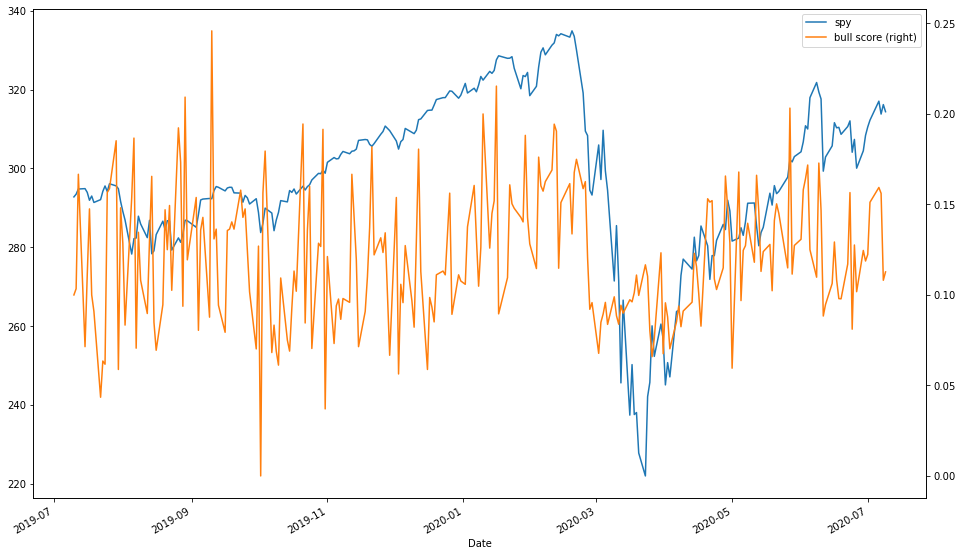

In [31]:
df_2[['spy', 'bull score']].loc['2019-07-10':].plot(secondary_y='bull score', figsize=(16, 10));

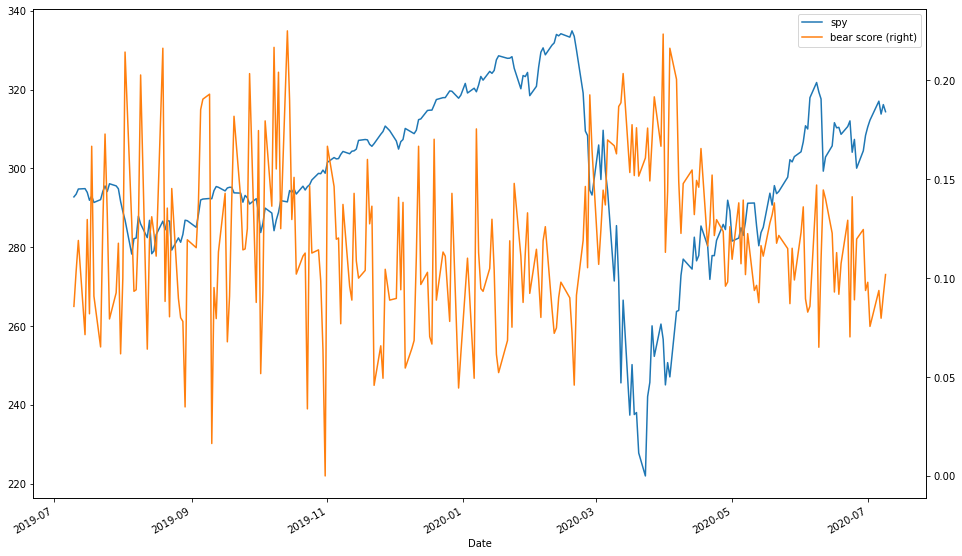

In [32]:
df_2[['spy', 'bear score']].loc['2019-07-10':].plot(secondary_y='bear score', figsize=(16, 10));

In [33]:
## fourier transform

close_fft = np.fft.fft(np.asarray(df_2['bull score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_2['fourier bull '+str(num_)]=np.fft.ifft(fft_list_m10)

close_fft = np.fft.fft(np.asarray(df_2['bear score'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [10, 30]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    df_2['fourier bear '+str(num_)]=np.fft.ifft(fft_list_m10)

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


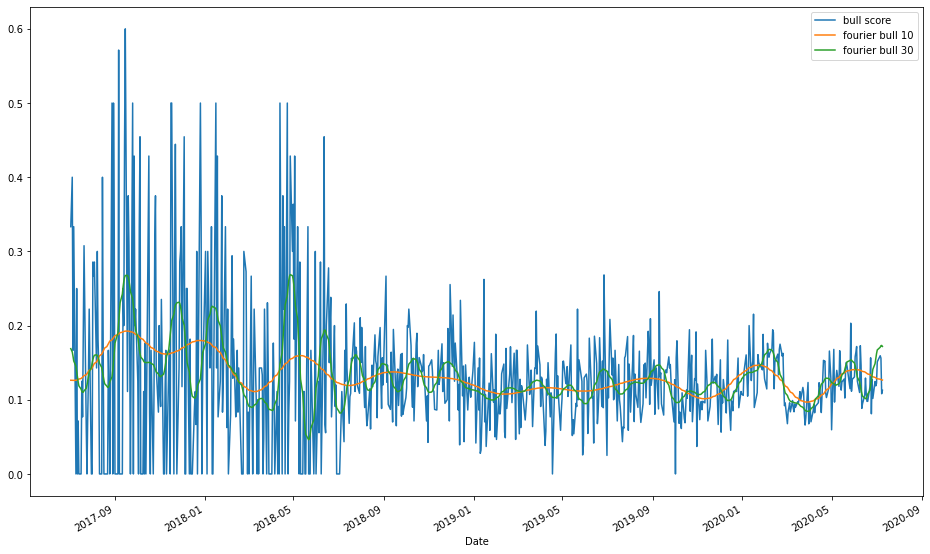

In [34]:
df_2[['bull score', 'fourier bull 10', 'fourier bull 30']].plot(figsize=(16, 10));

C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


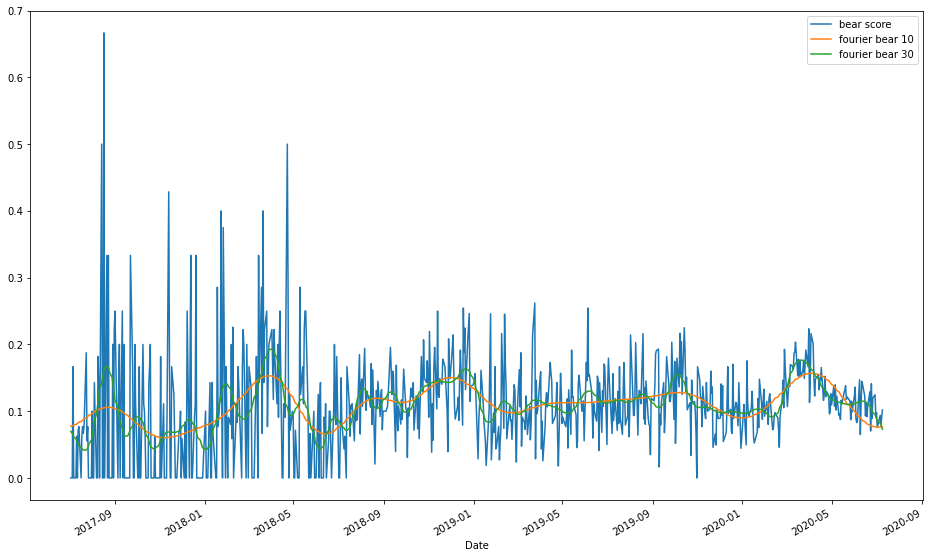

In [35]:
df_2[['bear score', 'fourier bear 10', 'fourier bear 30']].plot(figsize=(16, 10));

In [36]:
#normalize
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
df_2['norm_price']=sc.fit_transform(df_2['spy'].to_numpy().reshape(-1, 1))
df_2['spy log']=np.log(df_2['spy']/df_2['spy'].shift(1))
df_2['norm_bull']=sc.fit_transform(df_2['bull score'].to_numpy().reshape(-1, 1))
df_2['norm_bear']=sc.fit_transform(df_2['bear score'].to_numpy().reshape(-1, 1))
df_2['norm_fourier_bull_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2['fourier bull 10'].to_numpy()])).reshape(-1, 1))
df_2['norm_fourier_bear_10']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2['fourier bear 10'].to_numpy()])).reshape(-1, 1))
df_2['norm_fourier_bull_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2['fourier bull 30'].to_numpy()])).reshape(-1, 1))
df_2['norm_fourier_bear_30']=sc.fit_transform(np.asarray(list([(float(x)) for x in df_2['fourier bear 30'].to_numpy()])).reshape(-1, 1))


C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Arjun\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

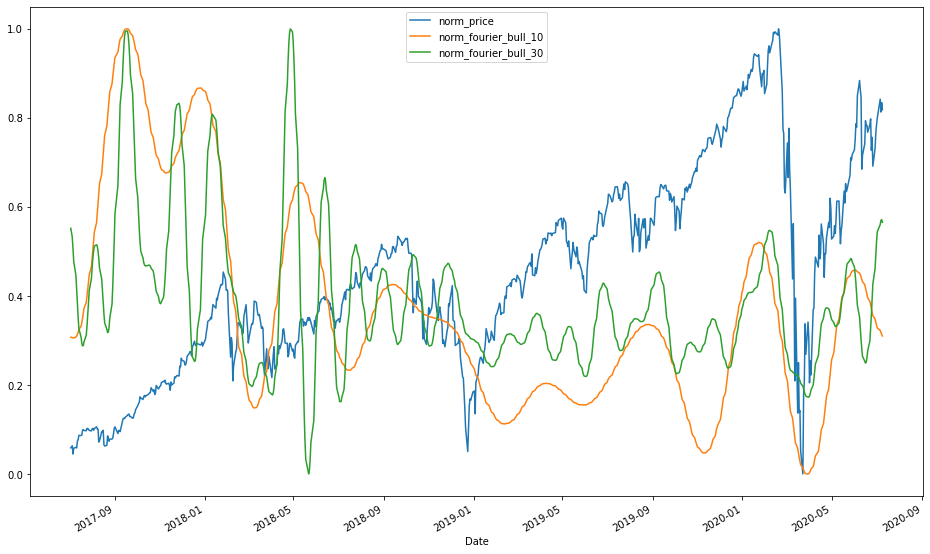

In [37]:
df_2[['norm_price', 'norm_fourier_bull_10', 'norm_fourier_bull_30']].plot(figsize=(16, 10));

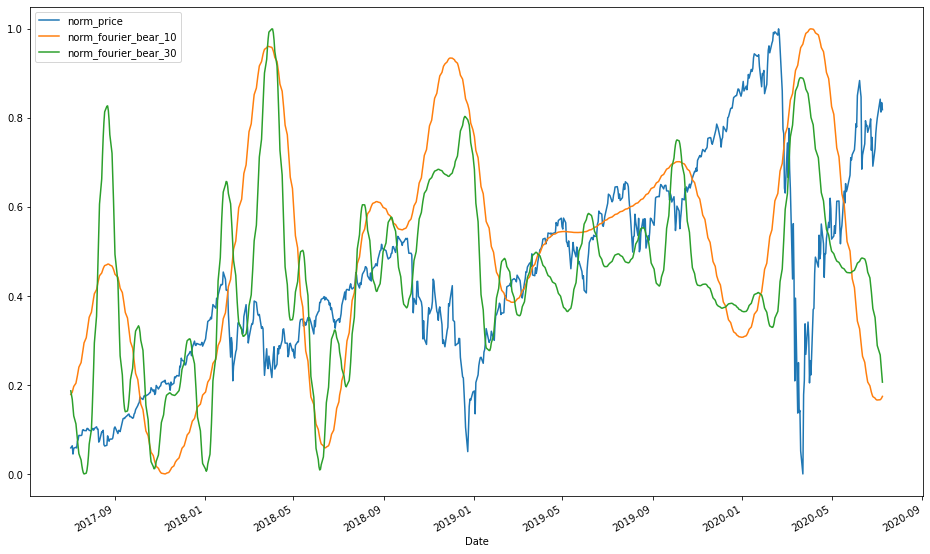

In [38]:
df_2[['norm_price', 'norm_fourier_bear_10', 'norm_fourier_bear_30']].plot(figsize=(16, 10));

# strategy development

## develop strategy using spread between sentiment score and spy

In [39]:
df_1[['norm_fourier20', 'norm_price']].corr()

,norm_fourier20,norm_price
norm_fourier20,1.000000,0.302571
norm_price,0.302571,1.000000


In [40]:
rolling_corr=df_1['norm_price'].rolling(window=14).corr(df_1['norm_fourier20'])
corr=df_1[['norm_fourier20', 'norm_price']].corr().iloc[0, 1]

mean=rolling_corr.mean()
print(mean)

std=np.std(rolling_corr)
print(std)

0.38866773944293925
0.5374435173587278


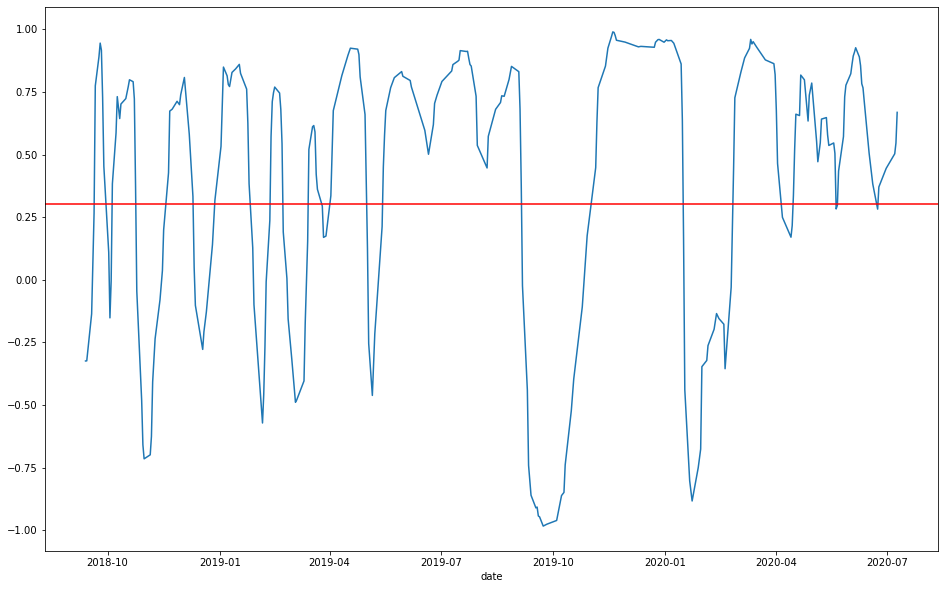

In [41]:
ax = rolling_corr.plot(figsize=(16, 10))  
ax.axhline(corr, c='r'); 

In [42]:
df_1['rolling_corr']=rolling_corr

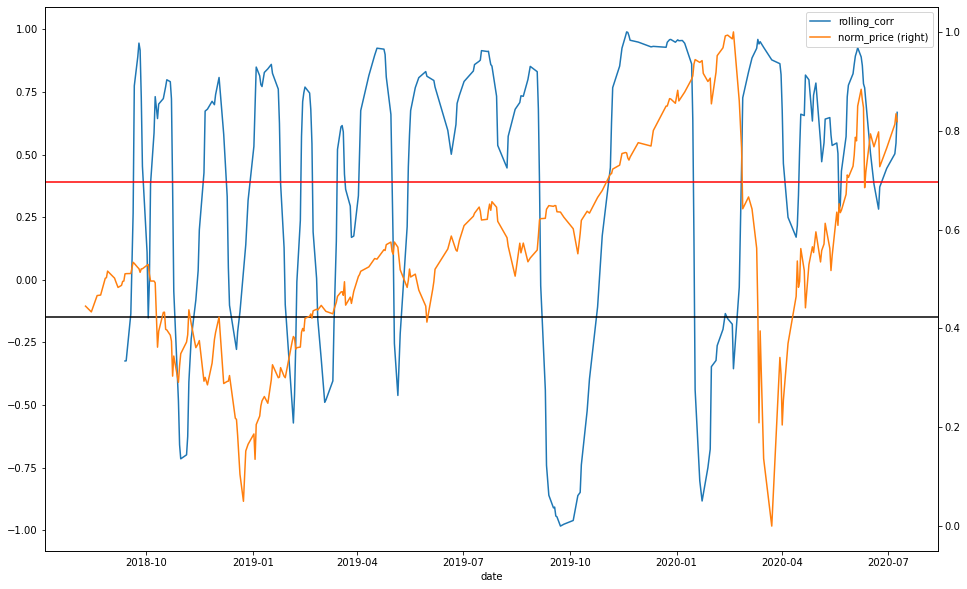

In [43]:
#rolling correlation vs price
#strategy could involve opening short position when correlation drops but spy continues to rise
ax=df_1[['rolling_corr', 'norm_price']].plot(secondary_y='norm_price', figsize=(16, 10))
ax.axhline(mean-std, c='black'); 
ax.axhline(mean, c='red');

## deep learning model based on bull/bear sentiment scores

In [44]:
#function for numpy array manipulation in next cell
def remove_first(array):
    new_array=[]
    for x in array:
        new_array.append(x[1:])
    return np.asarray(new_array)

In [45]:
# get relevant columns and divide into train and test sets
df=df_2[['norm_price', 'norm_bull', 'norm_bear', 'norm_fourier_bull_10', 
           'norm_fourier_bear_10', 'norm_fourier_bull_30', 'norm_fourier_bear_30']].to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-50]
test=data[-50:]
np.random.shuffle(train)

X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

In [46]:
#train lstm model
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_bullbear_sentiment_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, validation_data= [X_test, y_test], epochs=250, callbacks=[mc]).history

Train on 695 samples, validate on 50 samples
Epoch 1/250
695/695 [==============================] - 11s 15ms/sample - loss: 0.0757 - accuracy: 0.0014 - val_loss: 0.0923 - val_accuracy: 0.0000e+00
Epoch 2/250
695/695 [==============================] - 0s 356us/sample - loss: 0.0460 - accuracy: 0.0014 - val_loss: 0.0994 - val_accuracy: 0.0000e+00
Epoch 3/250
695/695 [==============================] - 0s 408us/sample - loss: 0.0415 - accuracy: 0.0014 - val_loss: 0.0780 - val_accuracy: 0.0000e+00
Epoch 4/250
695/695 [==============================] - 0s 408us/sample - loss: 0.0375 - accuracy: 0.0014 - val_loss: 0.0730 - val_accuracy: 0.0000e+00
Epoch 5/250
695/695 [==============================] - 0s 408us/sample - loss: 0.0333 - accuracy: 0.0014 - val_loss: 0.0646 - val_accuracy: 0.0000e+00
Epoch 6/250
695/695 [==============================] - 0s 412us/sample - loss: 0.0307 - accuracy: 0.0014 - val_loss: 0.0639 - val_accuracy: 0.0000e+00
Epoch 7/250
695/695 [============================

695/695 [==============================] - 0s 354us/sample - loss: 0.0039 - accuracy: 0.0029 - val_loss: 0.0677 - val_accuracy: 0.0000e+00
Epoch 55/250
695/695 [==============================] - 0s 357us/sample - loss: 0.0059 - accuracy: 0.0029 - val_loss: 0.0602 - val_accuracy: 0.0000e+00
Epoch 56/250
695/695 [==============================] - 0s 350us/sample - loss: 0.0053 - accuracy: 0.0029 - val_loss: 0.0545 - val_accuracy: 0.0000e+00
Epoch 57/250
695/695 [==============================] - 0s 353us/sample - loss: 0.0035 - accuracy: 0.0029 - val_loss: 0.0641 - val_accuracy: 0.0000e+00
Epoch 58/250
695/695 [==============================] - 0s 344us/sample - loss: 0.0030 - accuracy: 0.0029 - val_loss: 0.0526 - val_accuracy: 0.0000e+00
Epoch 59/250
695/695 [==============================] - 0s 351us/sample - loss: 0.0028 - accuracy: 0.0029 - val_loss: 0.0601 - val_accuracy: 0.0000e+00
Epoch 60/250
695/695 [==============================] - 0s 353us/sample - loss: 0.0026 - accuracy: 0.

Epoch 108/250
695/695 [==============================] - 0s 351us/sample - loss: 0.0011 - accuracy: 0.0029 - val_loss: 0.0437 - val_accuracy: 0.0000e+00
Epoch 109/250
695/695 [==============================] - 0s 351us/sample - loss: 0.0013 - accuracy: 0.0029 - val_loss: 0.0410 - val_accuracy: 0.0000e+00
Epoch 110/250
695/695 [==============================] - 0s 356us/sample - loss: 0.0014 - accuracy: 0.0029 - val_loss: 0.0464 - val_accuracy: 0.0000e+00
Epoch 111/250
695/695 [==============================] - 0s 353us/sample - loss: 0.0011 - accuracy: 0.0029 - val_loss: 0.0443 - val_accuracy: 0.0000e+00
Epoch 112/250
695/695 [==============================] - 0s 354us/sample - loss: 0.0013 - accuracy: 0.0029 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 113/250
695/695 [==============================] - 0s 354us/sample - loss: 0.0014 - accuracy: 0.0029 - val_loss: 0.0416 - val_accuracy: 0.0000e+00
Epoch 114/250
695/695 [==============================] - 0s 351us/sample - loss: 0

695/695 [==============================] - 0s 357us/sample - loss: 6.7624e-04 - accuracy: 0.0029 - val_loss: 0.0466 - val_accuracy: 0.0000e+00
Epoch 162/250
695/695 [==============================] - 0s 353us/sample - loss: 7.7759e-04 - accuracy: 0.0029 - val_loss: 0.0433 - val_accuracy: 0.0000e+00
Epoch 163/250
695/695 [==============================] - 0s 356us/sample - loss: 0.0030 - accuracy: 0.0029 - val_loss: 0.0463 - val_accuracy: 0.0000e+00
Epoch 164/250
695/695 [==============================] - 0s 351us/sample - loss: 0.0041 - accuracy: 0.0029 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 165/250
695/695 [==============================] - 0s 353us/sample - loss: 0.0017 - accuracy: 0.0029 - val_loss: 0.0417 - val_accuracy: 0.0000e+00
Epoch 166/250
695/695 [==============================] - 0s 351us/sample - loss: 0.0010 - accuracy: 0.0029 - val_loss: 0.0403 - val_accuracy: 0.0000e+00
Epoch 167/250
695/695 [==============================] - 0s 351us/sample - loss: 8.2099e

695/695 [==============================] - 0s 356us/sample - loss: 6.4205e-04 - accuracy: 0.0029 - val_loss: 0.0405 - val_accuracy: 0.0000e+00
Epoch 214/250
695/695 [==============================] - 0s 351us/sample - loss: 8.2311e-04 - accuracy: 0.0029 - val_loss: 0.0391 - val_accuracy: 0.0000e+00
Epoch 215/250
695/695 [==============================] - 0s 351us/sample - loss: 0.0012 - accuracy: 0.0029 - val_loss: 0.0299 - val_accuracy: 0.0000e+00
Epoch 216/250
695/695 [==============================] - 0s 357us/sample - loss: 0.0010 - accuracy: 0.0029 - val_loss: 0.0348 - val_accuracy: 0.0000e+00
Epoch 217/250
695/695 [==============================] - 0s 344us/sample - loss: 6.5024e-04 - accuracy: 0.0029 - val_loss: 0.0386 - val_accuracy: 0.0000e+00
Epoch 218/250
695/695 [==============================] - 0s 354us/sample - loss: 0.0011 - accuracy: 0.0029 - val_loss: 0.0348 - val_accuracy: 0.0000e+00
Epoch 219/250
695/695 [==============================] - 0s 349us/sample - loss: 0.0

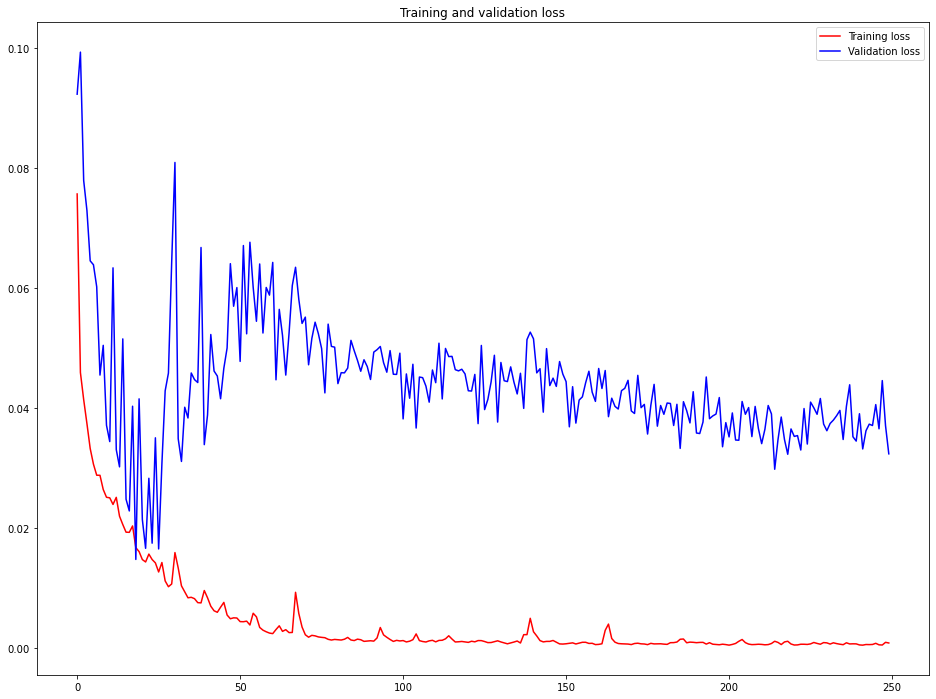

<Figure size 432x288 with 0 Axes>

In [47]:
#loss plot
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.figure(figsize = (16,12))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

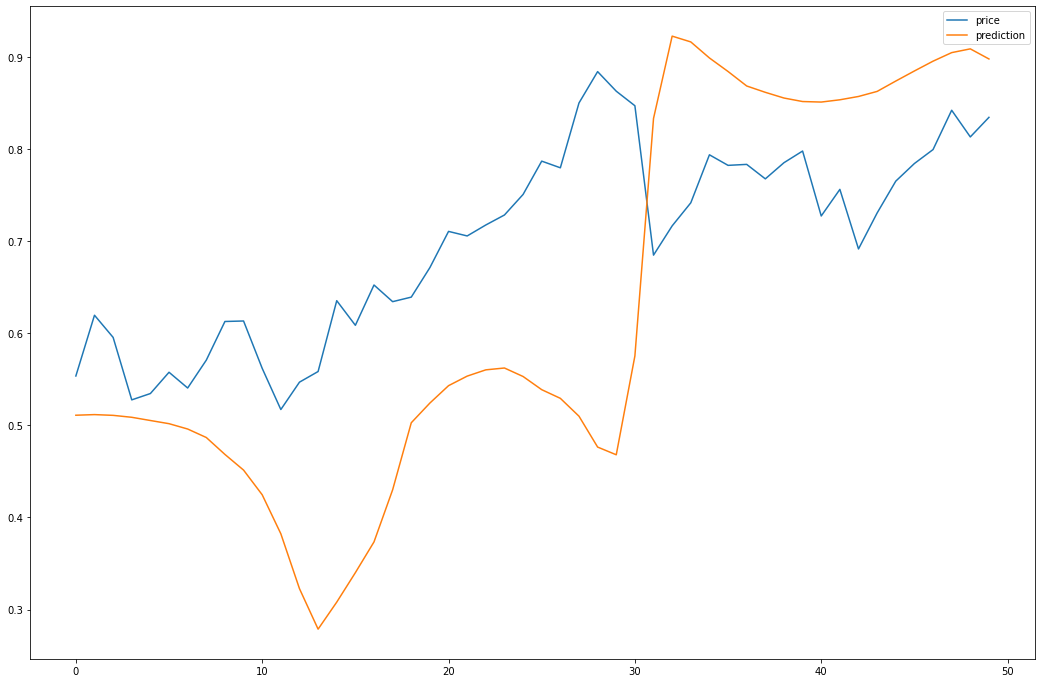

In [48]:
#predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

In [49]:
print('MEA: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MEA:  0.20830295741558075
